# 09. PyTorch Model Deployment

What is model deployment?

Machine learning deployment is the act of making your machine learning model(s) available to someone or something else.

## Resources:

* Book version: https://www.learnpytorch.io/09_pytorch_model_deployment/
* Github: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb

## 0. Get Setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.26 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
!ls going_modular/going_modular

data_setup.py  model_builder.py  __pycache__  train.py
engine.py      predictions.py	 README.md    utils.py


In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Getting Data

The dataset we're going to use for deployment of FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% samples)

We can get data: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
#Setup training and test path
train_dir=data_20_percent_path/"train"
test_dir=data_20_percent_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is my most ideal ML model deployment scenario?
2. Where is my model going to go?
3. How is my model going to fucntion?

**FoodVision Mini ideal use case:** A model that performs well and is fast

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible (30 FPS or 30ms latency)
  * Latency=time for prediction to take place

To try and achieve these goals, we're going to build two model experiments:
1. EffNetB2 feature extractor (just like in 07. EXperiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Papaer Replicating)

## 3. Creating an EffNetB2 feature extractor

Feature extractor=a term for transfer learning model that has its base layersfrozen and output layers (or head layers) customizd to a certain problem.

EffNetB2 pretrained model in PyTorch-https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html

In [ ]:
import torchvision
#1. setup pretrained EffNEtB2 weights
effnetb2_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT

#2. Get effnet transforms
effnetb2_transforms=effnetb2_weights.transforms()

#3. Get EffNetB2 model
effnetb2=torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers in the model (this will freeze all layers to begin with and stop layers from training)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 58.6MB/s]


In [ ]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=3)) # change out_features to suit our number of classes

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [ ]:
from torchinfo import summary
# # Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

### 3.3 Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9794 | train_acc: 0.5708 | test_loss: 0.7390 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.6835 | train_acc: 0.8771 | test_loss: 0.5929 | test_acc: 0.9347
Epoch: 3 | train_loss: 0.5640 | train_acc: 0.8958 | test_loss: 0.4816 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.4716 | train_acc: 0.8729 | test_loss: 0.4183 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.4308 | train_acc: 0.8729 | test_loss: 0.3723 | test_acc: 0.9659
Epoch: 6 | train_loss: 0.3738 | train_acc: 0.8979 | test_loss: 0.3456 | test_acc: 0.9506
Epoch: 7 | train_loss: 0.3373 | train_acc: 0.9062 | test_loss: 0.3132 | test_acc: 0.9568
Epoch: 8 | train_loss: 0.3248 | train_acc: 0.9250 | test_loss: 0.3009 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3671 | train_acc: 0.8562 | test_loss: 0.2747 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.2564 | train_acc: 0.9458 | test_loss: 0.2649 | test_acc: 0.9597


### 3.4 Inspecting EffNetB2 loss curves

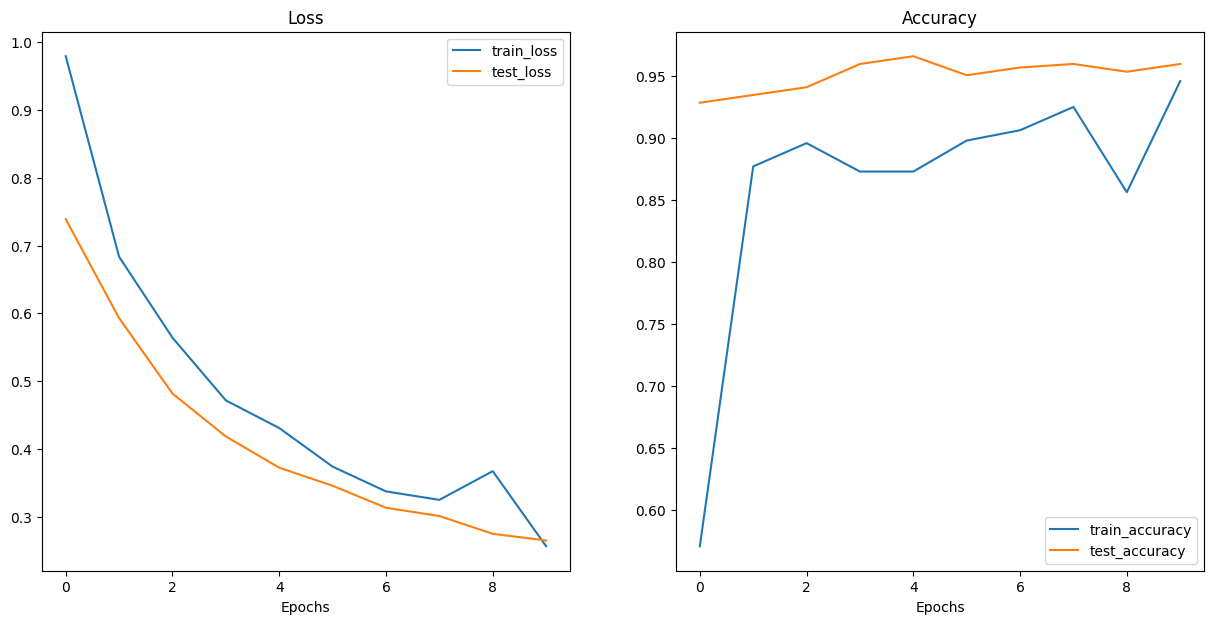

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

###3.5 Saving EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Checkcing the size of EffNetB2 feature extractor

Why consider size of saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large we may not be able to store/run it on our target device.

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2649004518985748,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Creating a ViT feature extractor

We're up to the second model and repeating the steps for EffNetB2 but this time with a ViT feature extractor (as in 08 PyTorch paper replication)

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 129MB/s]


In [ ]:
from torchinfo import summary

# # Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

## 4.2 Training ViT feature extrctor

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


###4.3 ViT loss curves

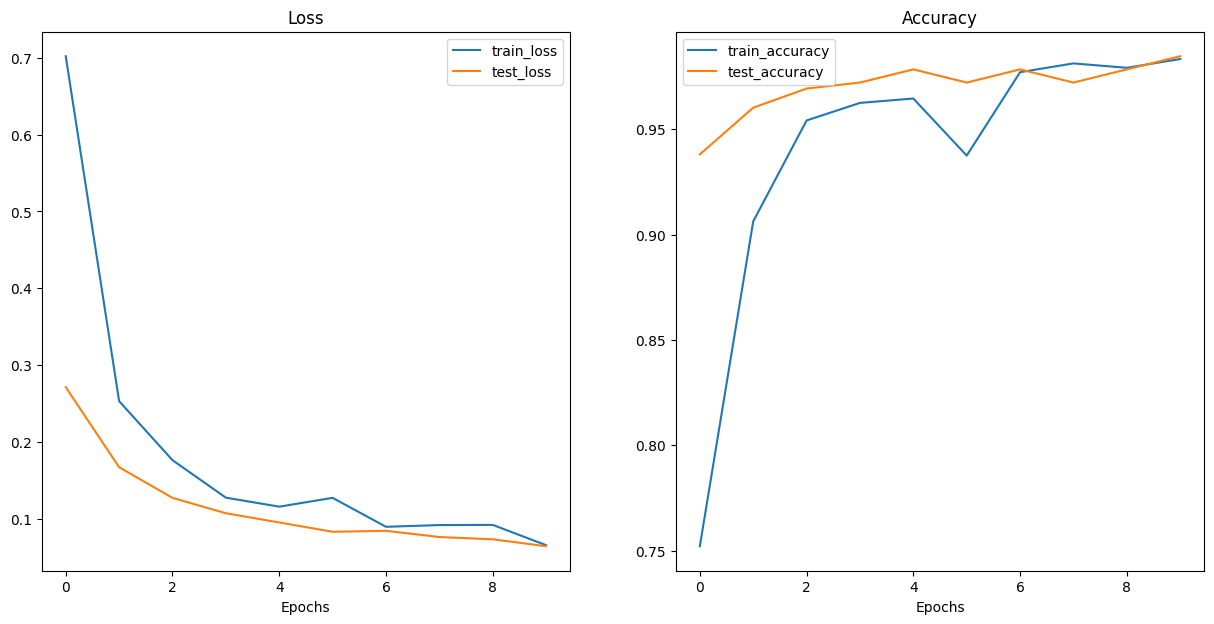

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT model

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking ViT size

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6 Collecting ViT feature extractor stats

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443446669727564,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30 FPS or 30ms latency)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Let work towards making a function called `pred_and_store` to do so.

First we'll need a list of test image paths.

In [ ]:
from pathlib import Path

#get all test data paths
test_data_paths=list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:3]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/40947.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg')]

from os import pread
### 5.1 Creating a function to make predictions across the test dataset

Steps to create `pred_and_store`:

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dicionary for each sample (prediction statistics will go on here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`
8. Transform the image to be usable with a given model.LookupError
9. Prepare the model for inference by senfing to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empt dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [ ]:
from tokenize import endpats
import pathlib
from PIL import Image
import torch

from timeit import default_timer as timer

from tqdm.auto import tqdm

from typing import List, Tuple, Dict

#1. Create a function which takes path list
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str="cuda" if torch.cuda.is_available() else "cpu")->List[Dict]:

  #2. create an empty list to return full list of predictions later
  pred_list=[]

  #3. Loop through the target input paths (rest of steps happen inside loop)
  for path in tqdm(paths):
    #4. Create an empty dictionary for each sample (prediction statistics will go on here)
    pred_dict={}

    #5. get sample path and ground truth class from filepath.
    pred_dict["image_path"]=path
    class_name=path.parent.stem
    pred_dict["class_name"]=class_name

    #6. Start prediction timer
    start_timer=timer()

    #7. Open the image using `PIL.Image.open(path)`
    img=Image.open(path)

    #8. Transform the image to be usable with a given model (add batch dim and send to target device)
    transformed_image=transform(img).unsqueeze(dim=0).to(device)

    #9. Prepare the model model for inference to the target device wil eval mode
    model=model.to(device)
    model.eval()

    #10. Turn on `torch.inference_mode() and pass the target transformed image to the model
    with torch.inference_mode():
      pred_logits=model(transformed_image)
      pred_prob=torch.softmax(pred_logits,dim=1) #turn logits into prediction probabilities
      pred_label=torch.argmax(pred_prob,dim=1) #turn pred probs into predicion labels
      pred_class=class_names[pred_label.cpu()] #find class name from class index / hardcode prediction class to be on CPU (Python variables live on the CPU)


    #11. Add the pred probs + pred class to empty dictionary from step 4
    pred_dict["pred_prob"]=round(pred_prob.unsqueeze(dim=0).max().cpu().item(),4)
    pred_dict["pred_class"]=pred_class

    #12. End prediction time
    end_timer=timer()
    pred_dict["pred_time"]=round(end_timer-start_timer,4)

    #13. See if predicted class matches the ground truth class
    pred_dict["correct"]=pred_dict["class_name"]==pred_dict["pred_class"]

    #14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
    pred_list.append(pred_dict)

  #15. return pred_list
  return pred_list

### 5.2 Making and timing predictions with EffNEtB2

Let's test our `pred_and_store()` function on EffNetB2.

Two things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images with the appropriate transforms (eg EffNetB2 with `effnetb2_transforms`).

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9321,
  'pred_class': 'steak',
  'pred_time': 0.2137,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/40947.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8911,
  'pred_class': 'steak',
  'pred_time': 0.1448,
  'correct': True}]

In [ ]:
 # Turn test pred_dicts into a DataFram
 import pandas as pd
 effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
 effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9321,steak,0.2137,True
1,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.8911,steak,0.1448,True
2,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9728,steak,0.1389,True
3,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.8680,steak,0.1660,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8662,steak,0.1717,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.pred_time.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1595 seconds


**Note**: Prediction times will vary (much like training times) depending on the hardware you're using..so generally the faster your compute (e.g CPU or GPU) the faster your predictions.

In [ ]:
# add time per pred to EFfNEtB2 stats dict
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2649004518985748,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1595}

### 5.3 Making and timing predictions with ViT

In [ ]:
#make list of prediction dictionaries for ViT model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                    model=vit,
                                    transform=vit_transforms,
                                    class_names=class_names,
                                    device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9981,steak,0.7334,True
1,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9895,steak,0.7336,True
2,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9916,steak,0.7011,True
3,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9738,steak,0.6858,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9950,steak,0.6916,True


In [ ]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.pred_time.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.8042 seconds


In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443446669727564,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.8042}

## 6.Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.264900,95.97,7705221,29,0.1595,EffNetB2
1,0.064434,98.47,85800963,327,0.8042,ViT


Which model is better?
* `test_loss` (lower is better)-ViT
* `test_acc` (higher is better)-ViT
* `number_of_parameters` (generally lower is better*)-if a model has more parameters, it generally takes longer to compute
  * *sometimes models with higher parameters can still perform fast
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` (lower is better, will be highly dependent on the hardward you're running on) - EffNetB2

Both models fail to achieve our goal of 30+FPS...however we could always just try and use EffNetB2 and see how it goes.

In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.24324,1.02605,11.135432,11.275862,5.042006


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualise the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model size (`model_size (MB)`)

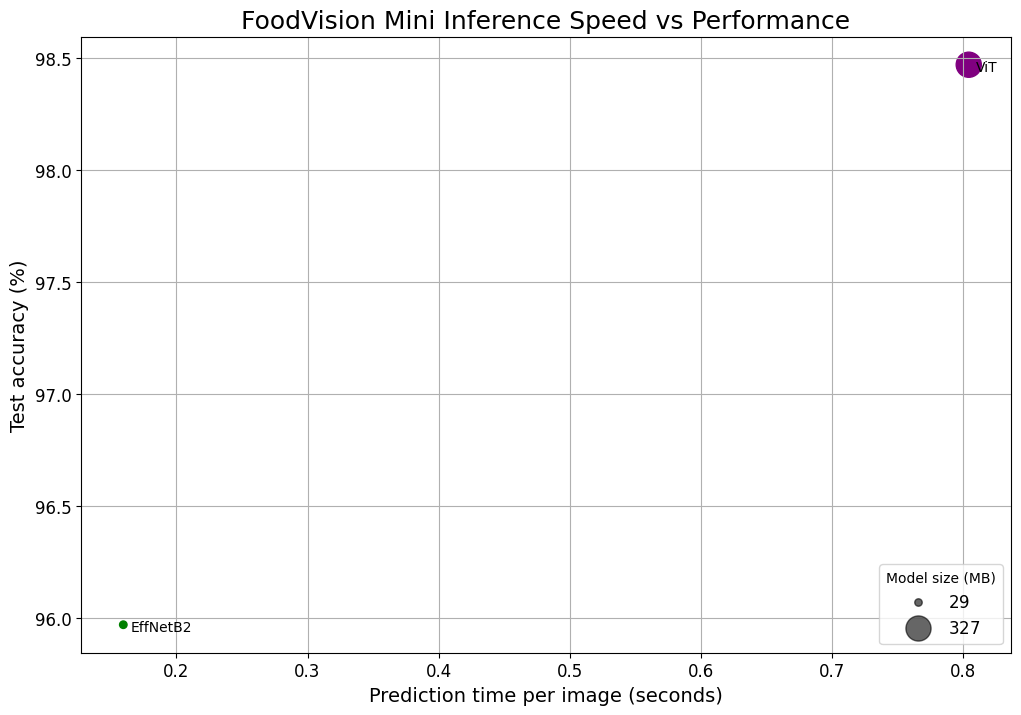

In [ ]:
# 1.Create a plot from model comparision DataFamw
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
scatter=ax.scatter(data=df,
                   x="time_per_pred_cpu",
                   y="test_acc",
                   c=["green", "purple"],
                   s="model_size (MB)")

#2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
# ax.legend(title="Model size (MB)",
#           bbox_to_anchor=(1.0, 1.0),
#           loc="upper left")

ax.grid(True)
#3. Annotate the samples on the scatter plot
for index, row in df.iterrows():
  ax.annotate(text=row.model,
              xy=(row.time_per_pred_cpu,
                  row.test_acc),
              xytext=(5, -5),
              textcoords="offset points")

#4. Create a legend based on the model sizes (model size (MB))
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)

model_size_legend=ax.legend(handles,
                            labels,
                            loc="lower right",
                            title="Model size (MB)",
                            fontsize=12)

#save figure
plt.savefig("09_pretrained_model_comparison.png")

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfills our criteria the best.

What is Gradio???

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere! https://www.gradio.app/



In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.5 MB/s e

### 7.1 Gradio overview

Gradio helps you create ML demos.

Why create a demo?

So other people can try our models and we can test them in the real world.

Deployment is as important as training for ML models.

### 7.2 Creating a function to map our inputs and outputs

In [ ]:
#put model on the CPU
effnetb2=effnetb2.to("cpu")

#check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food-> ML model (EffNetB2)-> outputs (food class label)
```

In [ ]:
from typing import Tuple, Dict

def predict(img)->Tuple[Dict, float]:
  #start timer
  start_time=timer()

  #open image

  #Transform the input image for use with EffNetB2
  img=effnetb2_transforms(img).unsqueeze(dim=0)

  #put model into eval mode and make predictions
  effnetb2.eval()
  with torch.inference_mode():
    # pass transformed image through the model and turn predictions logits into prob and
    pred_logits=effnetb2(img)
    pred_prob=torch.softmax(pred_logits,dim=1)
    pred_labels=torch.argmax(pred_prob,dim=1)
    pred_class=class_names[pred_labels]

  #end timer
  end_time=timer()
  pred_time=round(end_time-start_time,4)

  #create a prediction label and prediction probability dictionary
  pred_labels_and_probs={class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}

  #calculate pred time
  end_time=timer()
  pred_time=round(end_time-start_time,4)

  #Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

#get list of all test image file
test_data_paths=list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")


#get a random image path
random_image_path=random.sample(test_data_paths,k=1)[0]

#open the target image
image=Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}")

#make prediction
pred_dict, pred_time = predict(img=image)
print(f"[INFO] Prediction time: {pred_time} seconds")
print(pred_dict)

Example test data path: data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg
[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg
[INFO] Prediction time: 0.1383 seconds
{'pizza': 0.03320751711726189, 'steak': 0.8216686248779297, 'sushi': 0.1451239436864853}


### 7.3 Creating a list of example images

The examples for GRadio can be created with the `examples` parameter: https://gradio.app/docs/#building-demos

In [ ]:
# Create list of example inputs to our Gradio demo
example_list=[[str(filepath) for filepath in random.sample(test_data_paths,k=3)]]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg',
  'data/pizza_steak_sushi_20_percent/test/sushi/1203702.jpg',
  'data/pizza_steak_sushi_20_percent/test/steak/1882831.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image->transform->predict with `EffNEtB2`-> output: pred, prod prob, time
```

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2846d2b079308df344.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Google Colab are fantastic but they expire within 72 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spaces: https://huggingface.co/docs/hub/spaces

### 8.1 What is Hugging Face Spaces?

Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If Git hub is a place to show coding ability, Hugging Face Spaces is a place to show your machine learning ability (through sharing ML demos you've built).

### 8.2 Deployed Gradio app structure

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path `demos/foodvision_mini/` with the file structure

Let's start to put all of our app files into a single directory:

```
Colab->folder with all Gradio files->upload app files to Hugging Face Spaces-> deploy
```

By the end our fil structure will look like this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt

```

Why use this structure?

because it's one of the simplest we could start with.

You can see this in action:
* Deployed app: https://huggingface.co/spaces/mrdbourke/foodvision_mini
* See example file structure: https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main

### 8.3 Creating a `demos` folder to store our FoodVision app files

In [ ]:
import shutil
from pathlib import Path

#Create FoodVisionMini demo path
foodvision_mini_demo_path=Path("demos/foodvision_mini/")

#remove if exists and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,#
                                  exist_ok=True)

#check whats in the folder]
!ls demos/foodvision_mini

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

1. Create an `examples/` directory within the `demos/foodvision_mini` directory.
2. Choose three random images from the test dataset and collect their filepaths in a list.
3. Copy the three random images from the test dataset to the `demos/foodvision_mini/examples/` directory.

In [ ]:
import shutil
from pathlib import Path

In [ ]:
# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
#foodvision_mini_examples = example_list.squeeze(0)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination} as {example.name}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg as 592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg as 3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg as 2582289.jpg


Let's now verify that we can get a list of lists from our `examples/` directory.

In [ ]:
import os

#get example filepaths in a list of lists
example_list = [['examples/'+example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/2582289.jpg'], ['examples/592799.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil
from pathlib import Path

#create a source path for our target model
effnetb2_foodvision_mini_model_path =  "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

#Create a destination path for our target mode
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

print(effnetb2_foodvision_mini_model_destination)

#try to move the model file
try:
  print(f"[INFO] Copying {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  #move the model .move()
  shutil.copy2(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)

  print(f"[INFO] model move complete")

#if model has already been moved/copied check if exists
except:
  print(f"[INFO] Model exists at:{effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Copying models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] model move complete


### 8.6 Turning our EffNetB2 model into a Python script (`model.py`)

We have asaved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function into a Python script called `model.py`.

In [ ]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:
# from demos.foodvision_mini import model

# #get model and transforms
# effnetb2, effnetb2_transforms = model.create_effnetb2_model()

### 8.7 Turning our FoodVision Mini Gradio app into a Python script (app.py)

1. **Imports and class names setup** - Here we'll import the various dependencies for our demo including the `create_effnetb2_model()` function from `model.py` as well as setup the different class names for our FoodVision Mini app.

2. **Model and transforms preparation** - Here we'll create an EffNetB2 model instance along with the transforms to go with it and then we'll load in the saved model weights/`state_dict`. When we load the model we'll also set `map_location=torch.device("cpu")` in `torch.load()` so our model gets loaded onto the CPU regardless of the device it trained on (we do this because we won't necessarily have a GPU when we deploy and we'll get an error if our model is trained on GPU but we try to deploy it to CPU without explicitly saying so).

3. **Predict function** - Gradio's `gradio.Interface()` takes a `fn` parameter to map inputs to outputs, our `predict()` function will be the same as the one we defined above in section 7.2: Creating a function to map our inputs and outputs (https://www.learnpytorch.io/09_pytorch_model_deployment/#72-creating-a-function-to-map-our-inputs-and-outputs), it will take in an image and then use the loaded transforms to preprocess it before using the loaded model to make a prediction on it.
  **Note**: We'll have to create the example list on the fly via the `examples` parameter. We can do so by creating a list of the files inside the `examples/` directory with: `[["examples/" + example]` `for example in os.listdir("examples")`].

4. **Gradio app** - This is where the main logic of our demo will live, we'll create a `gradio.Interface()` instance called `demo` to put together our inputs, `predict()` function and outputs. And we'll finish the script by calling `demo.launch()` to launch our FoodVision Mini demo!

In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, #print errors locally?
            share=True) #generate a publically shareable URL

Writing demos/foodvision_mini/app.py


### 8.8 Create a requirements file for FoodVision Mini (`requirements.txt`)

The requirements file will tell Hugging Face Space what software dependencies our app requires.

3 main ones:

1. torch==1.12.0
2. torchvision==0.13.0
3. gradio==3.1.4

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Space

### 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces

In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   requirements.txt
examples


In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__"  "*.ipynb_checkpoints"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


In [ ]:
#Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running on Google Colab, can't use google.colab.files.download(), please download manually mate")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our FoodVision Mini demo locally

If you download the foodvision_mini.zip file, you can test it locally by:

1. Unzipping the file.
2. Opening terminal or a command line prompt.
3. Changing into the `foodvision_mini` directory (`cd foodvision_mini`).
4. Creating an environment (`python3 -m venv env`).
5. Activating the environment (`source env/bin/activate`).
6. Installing the requirements (`pip install -r requirements.txt`, the "`-r`" is for recursive).
  Note: This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade pip first: `pip install --upgrade pip`.
7. Run the app (`python3 app.py`).
This should result in a Gradio demo just like the one we built above running locally on your machine at a URL such as `http://127.0.0.1:7860/`.

### 9.3 Uploading to Hugging Face

1. Sign up for a Hugging Face account (https://huggingface.co/welcome).
2. Start a new Hugging Face Space by going to your profile and then clicking "New Space" (https://huggingface.co/new-space).
  * **Note**: A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_mini`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_mini
4. Select a license (I used MIT (https://opensource.org/license/MIT)).
5. Select Gradio as the Space SDK (software development kit).
  * **Note**: You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running something like: `git clone` `https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
  * **Note**: You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_mini` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to install Git LFS(https://git-lfs.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_mini` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
  * Track EffNetB2 PyTorch model file with git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth".
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the FoodVision Mini Hugging Face Space https://huggingface.co/spaces/mrdbourke/foodvision_mini/blob/main/.gitattributes.
  * `git add .gitattributes`
14. Add the rest of the `foodvision_mini` app files and commit them with:
  * `git add *`
  * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
  * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!


Command PRompt:
For command prompt:
- mkdir exampledirectoryname  (this should create a directory)
- dir (check all directories on machine 'exampledirectoryname' should be there)
- cd exampledirectoryname (move to exampledirectoryname directory)
- git clone https://huggingface.co/spaces/JJandmoreletters/foodvision_PSS (clone repo from hugging faces)
- dir C:\Users\martinj18\Downloads\foodvision_mini\* (check contents of folder)
-copy C:\Users\martinj18\Downloads\foodvision_mini.zip\* .(copy contents of folder into current directory)
- dir (check contents have been copied over with dir)
- git remote -v (check git repos)
- git lfs install (make sure it's installed)
- git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth" (track certain files)
- git lfs track "*.pth"
- git add * (add contents of directory to git)
- git status (status to check)
- git commit -m "initial commit" (commit changes)
- git push (push changes)

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_mini/+", width=900, height=750)

## 10. Creating FoodVision Big

Food vision mini works well with 3 classes (Pizza, Steak, Sushi).

So all our experimenting is paying off...

Let's step things up a notch and make FoodVision Big!!!

### 10.1 Creating a model and transforms for FoodVision Big

We can create an EffNetB2 feature extractor for Food101 by using our `create_effnetb2_model()` function we created above, in section 3.1, and passing it the parameter `num_classes=101` (since Food101 has 101 classes)

In [ ]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [ ]:
from torchinfo import summary

# # Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset we may want to introduce some data augmentation techniques:
* With a larger dataset and larger model, overfitting becomes more of a problem.
* Because we're working with a large number of classes let's use TrivialAugment as our data sugmentation

For a list of state of the art Computer vision recipes: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [ ]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [ ]:

print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### 10.2 Getting data for FoodVision Big

To get the whole Food101 dataset, we can use `torchvision.datasets.Food101()`.

We'll first setup a path to directory `data/` to store the images.

Then we'll download and transform the training and testing dataset splits using `food101_train_transforms` and `effnetb2_transforms` to transform each dataset respectively.

datasets: https://pytorch.org/vision/0.12/datasets.html
Food101: https://pytorch.org/vision/0.12/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

100%|██████████| 4996278331/4996278331 [03:08<00:00, 26495379.55it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of Food101 dataset for faster experimenting

Why create a subset?

We want our first few experiments to run as quick as possible

We know foodvision Mini works pretty well but this is the first time we've used 101 classes.

To do so, lets make a subset of 20% of the data from Fod 101 dataset (training and test)

Our short term goal: to beat the original Food 101 paper result of 56.40% accuracyon the test dataset (paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

We want to beat this result with modern deep learning techniques and only 20% of the data.

In [ ]:
from torch.utils.data import random_split # https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 10.4 Turning our Food101 datasets into DataLoaders

Now let's turn our Food101 20% dataset splits into DataLoader's using `torch.utils.data.DataLoader()`.

We'll set `shuffle=True` for the training data only and the batch size to `32` for both datasets.

And we'll set `num_workers` to `4` if the CPU count is available or `2` if it's not (though the value of `num_workers` is very experimental and will depend on the hardware you're using

In [ ]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### 10.5 Training FoodVision Big model

Things for training:
* 5 epochs
* Optimizer: torch.optim.Adam(lr=1e-3)
* loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Why use label smoothing?

Label smoothing helps to prevent overfitting (it's a regularization technique).

Without label smoothing and 5 classes:

```
[0.00,0.00,0.99,0.01,0.00]
```

With label smoothing and 5 classes:
```
[0.01,0.01,0.96,0.01,0.01]
```

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6409 | train_acc: 0.2770 | test_loss: 2.7822 | test_acc: 0.4898
Epoch: 2 | train_loss: 2.8526 | train_acc: 0.4408 | test_loss: 2.4815 | test_acc: 0.5359


### 10.6 Inspecting loss curves of FoodVision Big model

In [ ]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 10.7 Saving and loading FoodVision Big

In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

### 10.8 Checking FoodVision Big model size

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

## 11.Turning our FoodVision Big model into a deployable app

Why deploy a model? - Deploying a model allows you to see how your model goes in the real world (the ultimate test).

Outline for FoodVisionBig App:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```
Where:

* `09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our FoodVision Big Gradio app.
* `class_names.txt` contains all of the class names for FoodVision Big.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model defintion as well as any transforms assosciated with the model.
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`.

In [ ]:
from pathlib import Path

#Create Foodvision big demo path
foodvision_big_demo_path = Path("demos/foodvision_big")

#make foodvision big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                                exist_ok=True)

#make FoodVision Big demo examples directory
(foodvision_big_demo_path/"examples").mkdir(parents=True,
                                              exist_ok=True)

In [ ]:
!ls demos/foodvision_big/

### 11.1 Downloading an example image and moving it to the `examples` directory

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg

In [ ]:
!mv models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth demos/foodvision_big/

### 11.2 Saving Food101 class names to file (`class_names.txt`)

Save all the Food101 class names to a .txt file so we can import them into our app

In [ ]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

In [ ]:
#open Food 101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in f.readlines()]

# Check out the first X Food101 class names
food101_class_names_loaded[:5]

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=101,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 101.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

### 11.4 Turning our FoodVision Big Gradio app into a Python script (`app.py`)

1. **Imports and class names setup** - The `class_names` variable will be a list for all of the Food101 classes rather than pizza, steak, sushi. We can access these via `demos/foodvision_big/class_names.txt`.
2. **Model and transforms preparation** - The `model` will have `num_classes=101` rather than `num_classes=3`. We'll also be sure to load the weights from "`09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth`" (our FoodVision Big model path).
3. **Predict function** - This will stay the same as FoodVision Mini's `app.py`.
4. **Gradio app** - The Gradio interace will have different `title`, `description` and `article` parameters to reflect the details of FoodVision Big.

We'll also make sure to save it to `demos/foodvision_big/app.py` using the `%%writefile` magic command.

In [ ]:
%%writefile demos/foodvision_big/app.py
####1. Imports and class name setup###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

#Setup class names
with open("class_names.txt", "r") as f:
    class_names = f.readlines()
class_names = [class_name.strip() for class_name in class_names]

###2. Model and trnsfomr preparation

#Create model
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

#Load model weights
effnetb2_food101.load_state_dict(torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
                                            map_location=torch.device("cpu")))

###3. Predict function###

#create predict function###
def predict(img)->Tuple[Dict,float]:
  """Transform and perform prediction on img and returns prediction and time taken
  """
  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created through [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

### 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.3.1
torchvision==0.18.1
gradio==3.45.0

### 11.6 Downloading our FoodVision Big app files

In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

### 11.7 Deploying our FoodVision Big app to HuggingFace Spaces

1. Sign up for a Hugging Face account (https://huggingface.co/welcome).
2. Start a new Hugging Face Space by going to your profile and then clicking "New Space" (https://huggingface.co/new-space).
  * **Note**: A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_big`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_big
4. Select a license (I used MIT (https://opensource.org/license/MIT)).
5. Select Gradio as the Space SDK (software development kit).
  * **Note**: You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running something like: `git clone` `https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
  * **Note**: You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_big` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to install Git LFS(https://git-lfs.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_big` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
  * Track EffNetB2 PyTorch model file with `git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"`.
  * **Note:** If you get any errors uploading images, you may have to track them with `git lfs` too, for example `git lfs track "examples/04-pizza-dad.jpg"`
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the FoodVision Mini Hugging Face Space https://huggingface.co/spaces/mrdbourke/foodvision_mini/blob/main/.gitattributes.
  * `git add .gitattributes`
14. Add the rest of the `foodvision_big` app files and commit them with:
  * `git add *`
  * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
  * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

In [ ]:
# IPython is a library to help work with Python iteractively
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_big/+", width=900, height=750)

## Exercises

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [1]:
#get regular imports
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't import torchinfo...installing")
  !pip install torchinfo
  from torchinfo import summary

# try to import going modular file from github
try:
  from going_modular import data_setup, engine
except:
  print(f"[INFO] Couldn't import going_modular...downloading")
  !git clone https://github.com/jjandmoreletters/JJ-s-Code
  !mv JJ-s-Code/going_modular .
  !mv JJ-s-Code/helper_functions.py . # get the helper_functions.py script
  !rm -rf JJ-s-Code
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't import torchinfo...installing
  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)
[INFO] Couldn't import going_modular...downloading
Cloning into 'JJ-s-Code'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 227 (delta 3), reused 0 (delta 0), pack-reused 211
Receiving objects: 100% (227/227), 23.86 MiB | 16.25 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
import torch
import torchvision

####Get Data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi_20_percent")
image_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

Turn images into tensors in same way as in 08 Paper replication:-https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
#set batch size
BATCH_SIZE=32 #this is lower than the ViT paper as starting small

#create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b2970ab5270>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

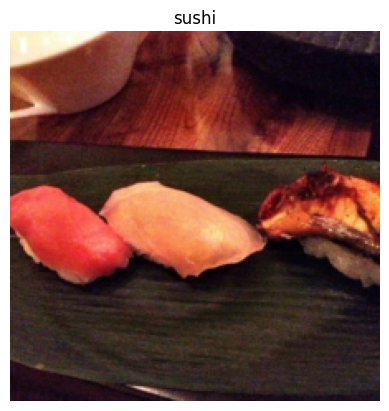

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

###Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

Train two models on Pizza, Steak, Sushi data
Need:

* Trained EffNetB2 feature extractor
* Trained ViT feature extractor

####EffNetB2
See function creation source here: https://www.learnpytorch.io/09_pytorch_model_deployment/#31-creating-a-function-to-make-an-effnetb2-feature-extractor

In [60]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

  #############

def create_effnetb2(out_features: int=len(class_names)):
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT #DEFAULT="best available weights"
  transforms=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights).to(device)
  dropout=0.3
  in_features=1408#model.classifier.in_features

  #freeze base layer
  for param in model.parameters():
    param.requires_grad=False

  #change classifier head
  set_seeds()

  #update classifier head
  model.classifier=nn.Sequential(nn.Dropout(p=dropout),
                                 nn.Linear(in_features=in_features,
                                           out_features=out_features)).to(device)

  #set model name
  model.name="effnetb2"
  print(f"Model name: {model.name}")
  return model, transforms

In [45]:
effnetb2, effnetb2_transforms = create_effnetb2()
# effnetb2
effnetb2_transforms

Model name: effnetb2


ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [46]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [47]:
# Create dataloaders for EffNetB2
from going_modular import data_setup

BATCH_SIZE = 32
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=BATCH_SIZE)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [48]:
#effnetb2_transforms

In [49]:
#effnetb2
image_b, label_b=next(iter(train_dataloader_effnetb2))
imag, labe = image_b[0], label_b[0]
imag

tensor([[[ 1.0159,  1.0331,  1.0331,  ..., -1.9809, -1.9638, -1.9467],
         [ 1.0331,  1.0502,  1.0502,  ..., -1.9295, -1.9467, -1.9809],
         [ 1.0502,  1.0673,  1.0844,  ..., -1.9467, -1.9809, -1.9809],
         ...,
         [ 0.7419,  0.7077,  0.6392,  ..., -1.4158, -1.4329, -1.5185],
         [ 0.7591,  0.7762,  0.6906,  ..., -1.5699, -1.4672, -1.4158],
         [ 0.8447,  0.8276,  0.7591,  ..., -1.5699, -1.5014, -1.5014]],

        [[ 0.7129,  0.7304,  0.7304,  ..., -1.9657, -1.9132, -1.8957],
         [ 0.7304,  0.7479,  0.7479,  ..., -1.9132, -1.8957, -1.9307],
         [ 0.7479,  0.7654,  0.7829,  ..., -1.9307, -1.9307, -1.9307],
         ...,
         [ 0.3277,  0.2752,  0.1352,  ..., -1.5805, -1.5980, -1.6856],
         [ 0.3627,  0.3452,  0.2052,  ..., -1.7206, -1.6331, -1.5980],
         [ 0.4503,  0.3803,  0.2752,  ..., -1.7031, -1.6856, -1.7031]],

        [[ 0.3568,  0.3742,  0.3742,  ..., -1.6650, -1.6302, -1.6127],
         [ 0.3742,  0.3916,  0.3916,  ..., -1

In [50]:
# Train EffNetB2 feature extractor
from going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9721 | train_acc: 0.5646 | test_loss: 0.7355 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7212 | train_acc: 0.8458 | test_loss: 0.5855 | test_acc: 0.9381
Epoch: 3 | train_loss: 0.5809 | train_acc: 0.8583 | test_loss: 0.4873 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9021 | test_loss: 0.4301 | test_acc: 0.9347
Epoch: 5 | train_loss: 0.4347 | train_acc: 0.8938 | test_loss: 0.3884 | test_acc: 0.9352
Epoch: 6 | train_loss: 0.4180 | train_acc: 0.8875 | test_loss: 0.3501 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4243 | train_acc: 0.8708 | test_loss: 0.3241 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.3842 | train_acc: 0.8958 | test_loss: 0.3380 | test_acc: 0.9506
Epoch: 9 | train_loss: 0.3724 | train_acc: 0.8958 | test_loss: 0.3086 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3547 | train_acc: 0.8604 | test_loss: 0.2801 | test_acc: 0.9625


```
# With label_smoothing=0.1
# Epoch: 1 | train_loss: 1.0005 | train_acc: 0.5708 | test_loss: 0.7872 | test_acc: 0.9347
# Epoch: 2 | train_loss: 0.7704 | train_acc: 0.8500 | test_loss: 0.6603 | test_acc: 0.9409
# Epoch: 3 | train_loss: 0.6679 | train_acc: 0.8896 | test_loss: 0.5883 | test_acc: 0.9500
# Epoch: 4 | train_loss: 0.5608 | train_acc: 0.9146 | test_loss: 0.5522 | test_acc: 0.9318
# Epoch: 5 | train_loss: 0.5528 | train_acc: 0.9125 | test_loss: 0.5239 | test_acc: 0.9352
# Epoch: 6 | train_loss: 0.5718 | train_acc: 0.8875 | test_loss: 0.4973 | test_acc: 0.9597
# Epoch: 7 | train_loss: 0.5609 | train_acc: 0.8854 | test_loss: 0.4864 | test_acc: 0.9472
# Epoch: 8 | train_loss: 0.5457 | train_acc: 0.8958 | test_loss: 0.5050 | test_acc: 0.9318
# Epoch: 9 | train_loss: 0.5338 | train_acc: 0.8896 | test_loss: 0.4809 | test_acc: 0.9193
# Epoch: 10 | train_loss: 0.5417 | train_acc: 0.8500 | test_loss: 0.4654 | test_acc: 0.9625

# Without label_smoothing=0.1
# Epoch: 1 | train_loss: 0.9856 | train_acc: 0.5604 | test_loss: 0.7408 | test_acc: 0.9347
# Epoch: 2 | train_loss: 0.7175 | train_acc: 0.8438 | test_loss: 0.5869 | test_acc: 0.9409
# Epoch: 3 | train_loss: 0.5876 | train_acc: 0.8917 | test_loss: 0.4909 | test_acc: 0.9500
# Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9062 | test_loss: 0.4355 | test_acc: 0.9409
# Epoch: 5 | train_loss: 0.4290 | train_acc: 0.9104 | test_loss: 0.3915 | test_acc: 0.9443
# Epoch: 6 | train_loss: 0.4381 | train_acc: 0.8896 | test_loss: 0.3512 | test_acc: 0.9688
# Epoch: 7 | train_loss: 0.4245 | train_acc: 0.8771 | test_loss: 0.3268 | test_acc: 0.9563
# Epoch: 8 | train_loss: 0.3897 | train_acc: 0.8958 | test_loss: 0.3457 | test_acc: 0.9381
# Epoch: 9 | train_loss: 0.3749 | train_acc: 0.8812 | test_loss: 0.3129 | test_acc: 0.9131
# Epoch: 10 | train_loss: 0.3757 | train_acc: 0.8604 | test_loss: 0.2813 | test_acc: 0.9688
```

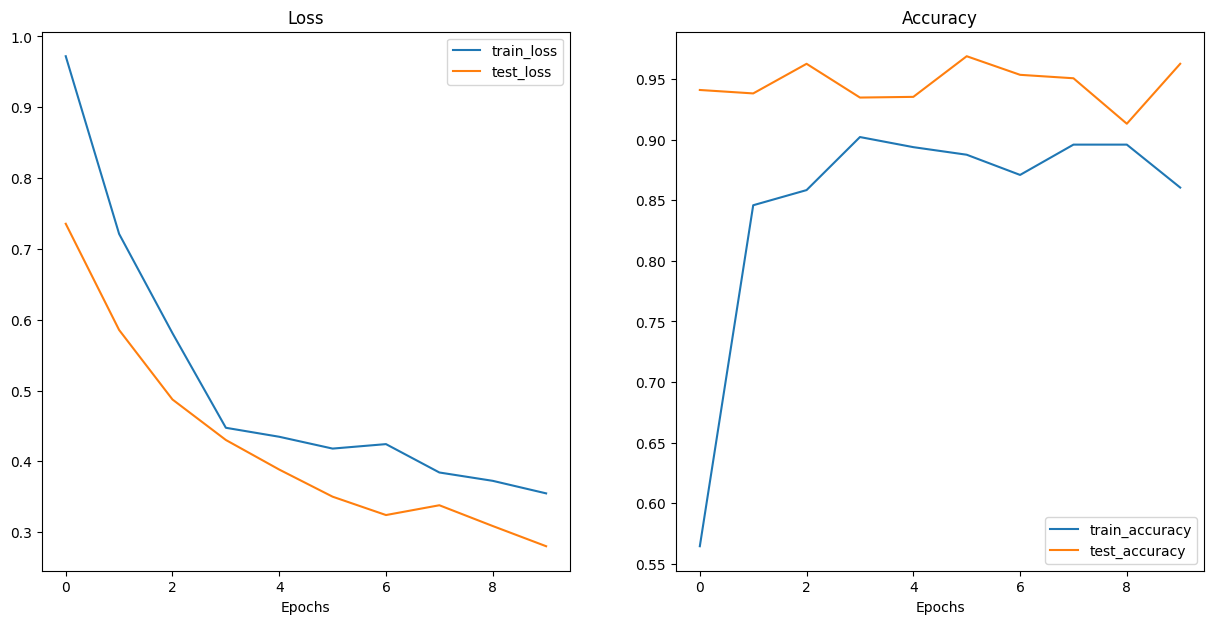

In [51]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

#### Preparing and training ViT feature extractor

In [75]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [76]:
vit, vit_transforms=create_vit_model()
#vit
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [77]:
#create vit dataloaders
from going_modular import data_setup

BATCH_SIZE=32
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=BATCH_SIZE)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [78]:
#next(iter(train_dataloader_vit))
#vit.parameters()
#vit

In [79]:
# Train ViT feature extractor
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


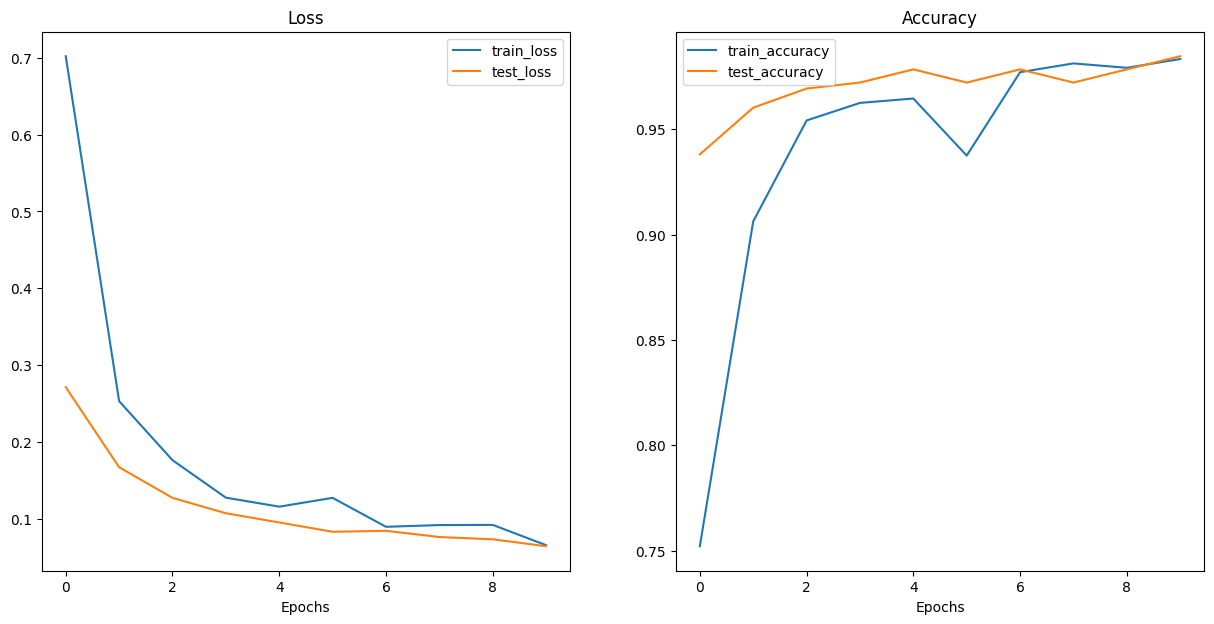

In [80]:
plot_loss_curves(vit_results)

#### Get all images from test path#

make predictions across the test dataset images and time against GPU and CPU

In [81]:
from pathlib import Path
test_image_paths = list(Path(test_dir).glob("*/*.jpg"))
len(test_image_paths)
test_image_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2819945.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/804460.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1383396.jpg')]

####Get function for making predictions and timing them
> See the source here: https://www.learnpytorch.io/09_pytorch_model_deployment/#51-creating-a-function-to-make-predictions-across-the-test-dataset

In [82]:
####Function for making predicionts and timing them###
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model = model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [83]:
# Make and time predictions on CPU
effnetb2_preds_on_cpu = pred_and_store(paths=test_image_paths,
                                       model=effnetb2,
                                       transform=effnetb2_transforms,
                                       class_names=class_names,
                                       device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [84]:
# Make and time predictions on CPU
vit_preds_on_cpu = pred_and_store(paths=test_image_paths,
                                       model=vit,
                                       transform=vit_transforms,
                                       class_names=class_names,
                                       device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [85]:
# Make and time predictions on GPU
effnetb2_preds_on_gpu = pred_and_store(paths=test_image_paths,
                                       model=effnetb2,
                                       transform=effnetb2_transforms,
                                       class_names=class_names,
                                       device="cuda")

vit_preds_on_gpu = pred_and_store(paths=test_image_paths,
                                  model=vit,
                                  transform=vit_transforms,
                                  class_names=class_names,
                                  device="cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [86]:
#comparing times
import pandas as pd

def get_mean_pred_time(input):
  df = pd.DataFrame(input)
  return df.time_for_pred.mean()

effnetb2_cpu_pred_time = get_mean_pred_time(effnetb2_preds_on_cpu)
effnetb2_cpu_pred_time

0.10954333333333333

In [87]:
effnetb2_gpu_pred_time = get_mean_pred_time(effnetb2_preds_on_gpu)
vit_cpu_pred_time = get_mean_pred_time(vit_preds_on_cpu)
vit_gpu_pred_time = get_mean_pred_time(vit_preds_on_gpu)

pred_times = {"effnetb2_cpu": effnetb2_cpu_pred_time,
              "vit_cpu": vit_cpu_pred_time,
              "effnetb2_gpu": effnetb2_gpu_pred_time,
              "vit_gpu": vit_gpu_pred_time}

pred_times_df = pd.DataFrame(pred_times, index=[0])
pred_times_df

,effnetb2_cpu,vit_cpu,effnetb2_gpu,vit_gpu
0,0.109543,0.522403,0.038301,0.020379


####Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

In [88]:
# Create another ViT feature model instance
vit_food101_20_percent, vit_transforms = create_vit_model(num_classes=101)

# Print ViT model summary (uncomment for full output)
from torchinfo import summary
summary(vit_food101_20_percent,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [89]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
#Use data augmentation to rpevent overfitting
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [90]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms, # perform normal ViT transforms on test data
                             download=True)

100%|██████████| 4996278331/4996278331 [03:45<00:00, 22145321.99it/s]


Extracting data/food-101.tar.gz to data


In [91]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [92]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [93]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [94]:
# Turn torch Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2
train_dataloader_food101 = DataLoader(train_data_food101_20_percent,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_food101 = DataLoader(test_data_food101_20_percent,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

len(train_dataloader_food101), len(test_dataloader_food101)

(474, 158)

In [95]:
#TRain ViT on 20% Food101 dataset
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = torch.optim.Adam(params=vit_food101_20_percent.parameters(),
                             lr=1e-3)

# Train the model
set_seeds()
vit_food101_20_percent_results = engine.train(model=vit_food101_20_percent,
                                              train_dataloader=train_dataloader_food101,
                                              test_dataloader=test_dataloader_food101,
                                              epochs=5,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6257
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 1.9249 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6981
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 1.8297 | test_acc: 0.7078


####Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions

In [96]:
# Loop through test DataLoader (with batch size 1)
# Make prediction with model
# Store prediction and prediction probability to dictionary
# Append dictionary to list
# Inspect list

# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_batch_size_1 = DataLoader(test_data_food101_20_percent,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  num_workers=NUM_WORKERS)

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_pred_list.append(pred_dict)

  0%|          | 0/5050 [00:00<?, ?it/s]

In [ ]:
# Create DataFrame with various columns
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

# Create a column for if the prediction is correct
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]

# Create class name columns (e.g. pred_label=72 -> pred_class="pancakes")
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent.head()

In [98]:
# Get top 10 samples that are "most wrong", e.g. highest pred_prob but wrong prediction - why??
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

,pred_prob,pred_label,label,is_correct,pred_class,label_class
3107,0.9834614,52,32,False,gyoza,dumplings
1306,0.94412065,71,44,False,paella,fried_rice
2848,0.9294365,41,8,False,french_onion_soup,bread_pudding
708,0.90649515,9,12,False,breakfast_burrito,cannoli
1726,0.8809202,68,43,False,onion_rings,fried_calamari
3436,0.8750597,45,58,False,frozen_yogurt,ice_cream
2287,0.8635277,38,28,False,fish_and_chips,croque_madame
3209,0.85735285,9,36,False,breakfast_burrito,falafel
1338,0.85360825,15,51,False,ceviche,guacamole
1872,0.84609723,79,37,False,prime_rib,filet_mignon


####Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?

In [99]:
# Check length of Food101 test data
len(test_data)

25250

In [100]:
# Turn Food101 test data into DataLoader
# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_all_data_batch_size_1 = DataLoader(test_data,
                                                           batch_size=1,
                                                           shuffle=False,
                                                           num_workers=NUM_WORKERS)

len(test_dataloader_food101_all_data_batch_size_1)

25250

In [101]:
# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_all_test_data_pred_list = []
for X, y in tqdm(test_dataloader_food101_all_data_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_all_test_data_pred_list.append(pred_dict)

  0%|          | 0/25250 [00:00<?, ?it/s]

In [ ]:
# Evalaute model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

In [103]:
# Calculate accuracy across Food101 all test
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")

Accuracy of ViT model on all of Food101 test data: 0.2931089108910891
Accuracy of ViT model on all of Food101 test data: 0.2931089108910891
